In [3]:
%autosave 5

#  Import required libraries
import numpy as np
import pandas as pd
%matplotlib inline

#  Import our custom set of normalization functions
import normalizations



Autosaving every 5 seconds


In [4]:
#  Load the dataset as a pandas DataFrame
bitcoin = pd.read_csv("/content/bitcoin_historical_prices.csv")

#  Change `date` column to datetime type
bitcoin['date'] = pd.to_datetime(bitcoin['date'])
bitcoin.head()

,date,iso_week,open,high,low,close,volume,market_capitalization
0,2013-04-28,2013-17,135.30,135.98,132.10,134.21,NaN,1.500520e+09
1,2013-04-29,2013-17,134.44,147.49,134.00,144.54,NaN,1.491160e+09
2,2013-04-30,2013-17,144.00,146.93,134.05,139.00,NaN,1.597780e+09
3,2013-05-01,2013-17,139.00,139.89,107.72,116.99,NaN,1.542820e+09
4,2013-05-02,2013-17,116.38,125.60,92.28,105.21,NaN,1.292190e+09


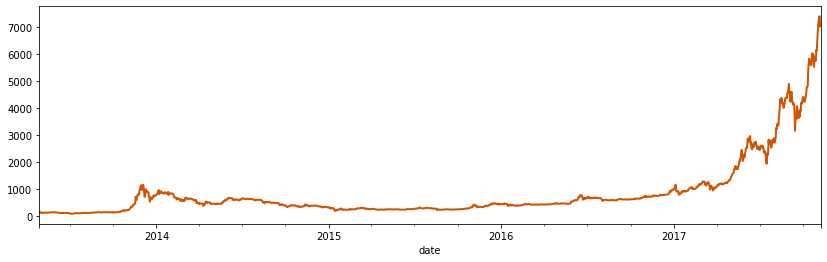

In [5]:
#  Time-series plot for `close` variable
bitcoin.set_index('date')['close'].plot(
    linewidth=2,
    figsize=(14, 4),
    color='#d35400');

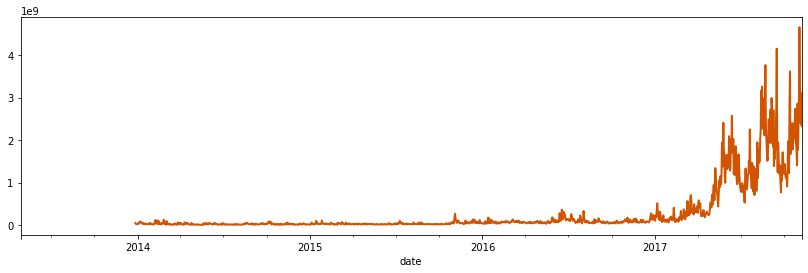

In [6]:
#  TASK:
#  Make a time-series plot for `volume` variable here.
#  How different is the volume data compared to 
#  the closing prices every day?
bitcoin.set_index('date')['volume'].plot(
    linewidth=2,
    figsize=(14, 4),
    color='#d35400');

In [7]:
# Filter for newer or equal to Jan 1, 2016
bitcoin_recent = bitcoin[bitcoin['date'] >= '2016-01-01']

In [8]:
#  Keep only the `close` and `volume` variables
bitcoin_recent = bitcoin_recent[['date', 'iso_week', 'close', 'volume']]

In [9]:
#  Normalize our data for the the `close` variable.
bitcoin_recent['close_point_relative_normalization'] = bitcoin_recent.groupby('iso_week')['close'].apply(
lambda x:normalizations.z_score(x))

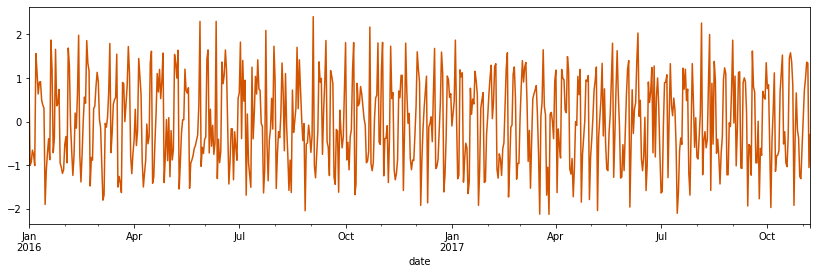

In [10]:
#  Plot for normalized variable `close_point_relative_normalization`
bitcoin_recent.set_index('date')['close_point_relative_normalization'].plot(figsize=(14, 4), color='#d35400');

In [11]:
#  TASK:
#  Normalize our data for the the `volume` variable.
#  Use the name: `volume_point_relative_normalization`
bitcoin_recent['volume_point_relative_normalization'] = bitcoin_recent.groupby('iso_week')['volume'].apply(
lambda x:normalizations.z_score(x))

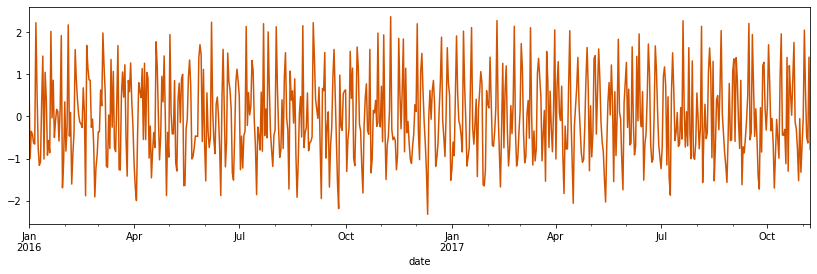

In [12]:
bitcoin_recent.set_index('date')['volume_point_relative_normalization'].plot(figsize=(14, 4), color='#d35400');

In [13]:
#  Use the last 20% of available weeks as a test set and the first 80% as a training set.
boundary = int(0.8 * bitcoin_recent['iso_week'].nunique())
train_set_weeks = bitcoin_recent['iso_week'].unique()[0:boundary]
test_set_weeks = bitcoin_recent[~bitcoin_recent['iso_week'].isin(train_set_weeks)]['iso_week'].unique()

print(train_set_weeks)
print(test_set_weeks)

['2016-00' '2016-01' '2016-02' '2016-03' '2016-04' '2016-05' '2016-06'
 '2016-07' '2016-08' '2016-09' '2016-10' '2016-11' '2016-12' '2016-13'
 '2016-14' '2016-15' '2016-16' '2016-17' '2016-18' '2016-19' '2016-20'
 '2016-21' '2016-22' '2016-23' '2016-24' '2016-25' '2016-26' '2016-27'
 '2016-28' '2016-29' '2016-30' '2016-31' '2016-32' '2016-33' '2016-34'
 '2016-35' '2016-36' '2016-37' '2016-38' '2016-39' '2016-40' '2016-41'
 '2016-42' '2016-43' '2016-44' '2016-45' '2016-46' '2016-47' '2016-48'
 '2016-49' '2016-50' '2016-51' '2016-52' '2017-01' '2017-02' '2017-03'
 '2017-04' '2017-05' '2017-06' '2017-07' '2017-08' '2017-09' '2017-10'
 '2017-11' '2017-12' '2017-13' '2017-14' '2017-15' '2017-16' '2017-17'
 '2017-18' '2017-19' '2017-20' '2017-21' '2017-22' '2017-23' '2017-24'
 '2017-25']
['2017-26' '2017-27' '2017-28' '2017-29' '2017-30' '2017-31' '2017-32'
 '2017-33' '2017-34' '2017-35' '2017-36' '2017-37' '2017-38' '2017-39'
 '2017-40' '2017-41' '2017-42' '2017-43' '2017-44' '2017-45']


In [14]:
#  Create train dataset
train_dataset = bitcoin_recent[bitcoin_recent['iso_week'].isin(train_set_weeks)]

In [15]:
#  TASK:
#  Create test dataset by performing the same operation as above.
#  Use the `test_set_weeks` list to create the variable `test_dataset`.
test_dataset = bitcoin_recent[bitcoin_recent['iso_week'].isin(test_set_weeks)]

In [16]:
bitcoin_recent.to_csv('bitcoin_recent.csv', index=False)
train_dataset.to_csv('train_dataset.csv', index=False)
test_dataset.to_csv('test_dataset.csv', index=False)

In [17]:
%autosave 5

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation

Autosaving every 5 seconds


In [18]:
#  TASK:
#  Define `period_length`
period_length=7

In [19]:
#  TASK:
#  Define `number_of_periods`
number_of_periods=76

In [20]:
def build_model(period_length, number_of_periods, batch_size=1):
    """Build an LSTM model using Keras.

    Parameters
    ----------
    period_length: int
        The size of each observation used as input.

    number_of_periods: int
        The number of periods available in the
        dataset.

    batch_size: int
        The size of the batch used in each training
        period.

    Returns
    -------
    model: Keras model
        Compiled Keras model that can be trained
        and stored in disk.
    """
    model = Sequential()
    model.add(LSTM(
        units=period_length,
        batch_input_shape=(batch_size, number_of_periods, period_length),
        input_shape=(number_of_periods, period_length),
        return_sequences=False, stateful=False))

    model.add(Dense(units=period_length))
    model.add(Activation("linear"))

    model.compile(loss="mse", optimizer="rmsprop")

    return model

In [21]:
model = build_model(period_length=period_length, number_of_periods=number_of_periods)

In [22]:
model.save('bitcoin_lstm_v0.h5')

In [23]:
%autosave 5

#  Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from keras.models import load_model

Autosaving every 5 seconds


In [24]:
#  Import training dataset
train = pd.read_csv('/content/train_dataset.csv')
train.head()

,date,iso_week,close,volume,close_point_relative_normalization,volume_point_relative_normalization
0,2016-01-01,2016-00,434.33,36278900.0,1.000000,1.000000
1,2016-01-02,2016-00,433.44,30096600.0,-1.000000,-1.000000
2,2016-01-03,2016-01,430.01,39633800.0,-0.925680,-0.354866
3,2016-01-04,2016-01,433.09,38477500.0,-0.652250,-0.417208
4,2016-01-05,2016-01,431.96,34522600.0,-0.752567,-0.630440


In [25]:
def create_groups(data, group_size=7):
    """Create distinct groups from a continuous series.
    
    Parameters
    ----------
    data: np.array
        Series of continious observations.

    group_size: int, default 7
        Determines how large the groups are. That is,
        how many observations each group contains.
    
    Returns
    -------
    A Numpy array object. 
    """
    samples = []
    for i in range(0, len(data), group_size):
        sample = list(data[i:i + group_size])
        if len(sample) == group_size:
            samples.append(np.array(sample).reshape(1, group_size))
    
    return np.array(samples)

In [26]:
#  Find the remainder when the number of observations is divided by group size
len(train) % 7

2

In [27]:
#  Create groups of 7 from our data.
#  We drop the first two observations so that the
#  number of total observations is divisible by the `group_size`.
data = create_groups(train['close_point_relative_normalization'][2:].values)
print(data.shape)

(77, 1, 7)


In [28]:
#  Reshape data into format expected by LSTM layer
X_train = data[:-1, :].reshape(1, 76, 7)
Y_validation = data[-1].reshape(1, 7)
print(X_train.shape)
print(Y_validation.shape)

(1, 76, 7)
(1, 7)


In [29]:
#  Load our previously trained model 
model = load_model('bitcoin_lstm_v0.h5')

In [30]:
%%time
#  Train the model
history = model.fit(
    x=X_train, y=Y_validation,
    batch_size=32, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 1.3313
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 1.2728
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 1.2324
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 1.1997
Epoch 5/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1714
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 1.1461
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 1.1230
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 1.1014
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 1.0810
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 1.0617
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 1.0431
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0252
Epoch 13/100
1/1 [==============================] - 0s 1ms/st

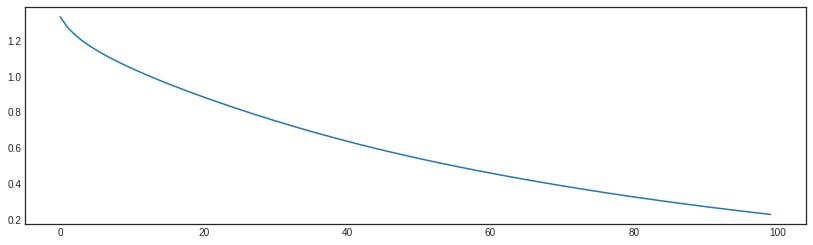

In [31]:
#  Plot loss function
pd.Series(history.history['loss']).plot(figsize=(14, 4));

In [32]:
#  Make predictions using X_train data
predictions = model.predict(x=X_train)[0]
predictions

array([-0.7901664 , -0.22382927,  0.65387666,  0.45560202,  0.14602195,
        1.0977699 , -0.7539202 ], dtype=float32)

In [33]:
def denormalize(series, last_value):
    """Denormalize the values for a given series.
    
    This uses the last value available (i.e. the last
    closing price of the week before our prediction)
    as a reference for scaling the predicted results.
    """
    result = last_value * (series + 1)
    return result

In [34]:
#  Denormalize predictions
last_weeks_value = train[train['date'] == train['date'][:-7].max()]['close'].values[0]

denormalized_prediction = denormalize(predictions, last_weeks_value)
denormalized_prediction

array([ 557.2929, 2061.4163, 4392.4976, 3865.9043, 3043.6968, 5571.4243,
        653.5584], dtype=float32)

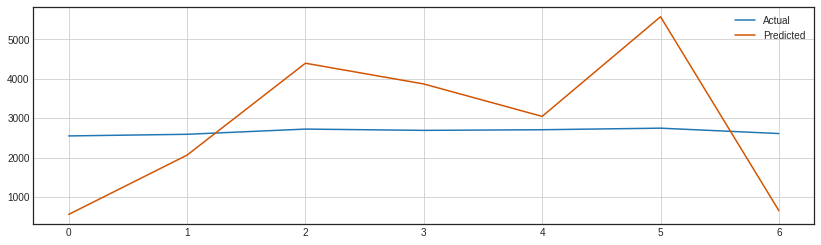

In [35]:
#  Plot denormalized predictions against actual predictions
plt.figure(figsize=(14, 4))

plt.plot(train['close'][-7:].values, label='Actual')
plt.plot(denormalized_prediction, color='#d35400', label='Predicted')

plt.grid()
plt.legend();

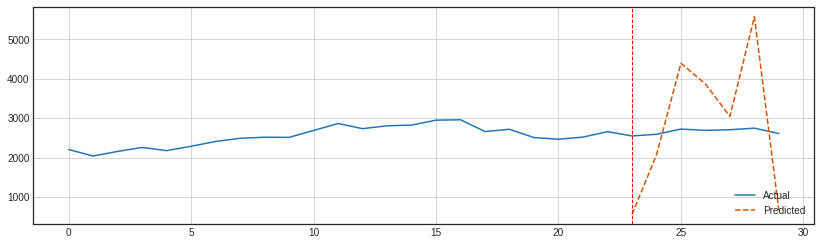

In [36]:
prediction_plot = np.zeros(len(train)-2)
prediction_plot[:] = np.nan
prediction_plot[-7:] = denormalized_prediction

plt.figure(figsize=(14, 4))
plt.plot(train['close'][-30:].values, label='Actual')
plt.plot(prediction_plot[-30:], color='#d35400', linestyle='--', label='Predicted')
plt.axvline(30 - 7, color='r', linestyle='--', linewidth=1)

plt.grid()
plt.legend(loc='lower right');

In [37]:
#  TASK:
#  Save model to disk
model.save_weights('bitcoin_lstm_v0_trained.h5')



In [39]:
%autosave 5

#  Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

from keras.models import load_model
from keras.callbacks import TensorBoard
from datetime import datetime, timedelta

from utilities_activity6 import *
np.random.seed(0)


Autosaving every 5 seconds


In [40]:
#  Load datasets
train = pd.read_csv("/content/train_dataset.csv")
test = pd.read_csv("/content/test_dataset.csv")

In [41]:
#  Group data into groups containing seven observations
train_data = create_groups(
    train['close_point_relative_normalization'][2:].values)

test_data = create_groups(
    test['close_point_relative_normalization'][:-3].values)

In [42]:
#  Reshape the data in the format expected by the LSTM layer
X_train, Y_train = split_lstm_input(train_data)

In [43]:
def train_model(model, X, Y, epochs, version, run_number):
    """Training a model with TensorBoard callback.

    This function names each run of the model
    using the TensorBoard naming conventions.

    Parameters
    ----------
    model: Keras model instance
        Compiled Keras model.

    X, Y: np.array
        Series of observations to be used in
        the training process.

    epochs: int
        The number of epochs to train the
        model for.

    version: int
        Version of the model to run.

    run_number: int
        The number of the run. Used in case
        the same model version is run again.
    """
    model_name = f'bitcoin_lstm_v{version}_run_{run_number}'
    tensorboard = TensorBoard(log_dir=f'./logs/{model_name}')

    #  TASK:
    #  Modify the `fit` method to include a TensorBoard callback.
    #
    model_history = model.fit(
        x=X, y=Y,
        batch_size=1, epochs=epochs,
        shuffle=False)

    return model_history

In [44]:
#  Load previously trained network
model = load_model('bitcoin_lstm_v0.h5')

In [45]:
#  Retrain network
model_history = train_model(model=model,
                            X=X_train, Y=Y_train,
                            epochs=100,
                            version=0, run_number=1)

Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 1.3313
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 1.2728
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 1.2324
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 1.1997
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 1.1714
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 1.1461
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 1.1230
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 1.1014
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 1.0810
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 1.0617
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0431
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 1.0252
Epoch 13/100
1/1 [==============================] - 0s 2ms/st

In [46]:
#  Combine training and testing datasets
combined_set = np.concatenate((train_data, test_data), axis=1)

In [47]:
#  Evaluate model at each week for the test set
evaluated_weeks = []
for i in range(0, test_data.shape[1]):
    input_series = combined_set[0:, i:i + 77]

    X_test = input_series[0:, :-1].reshape(1, input_series.shape[1] - 1, 7)
    Y_test = input_series[0:, -1:][0]

    result = model.evaluate(x=X_test, y=Y_test, verbose=0)
    evaluated_weeks.append(result)

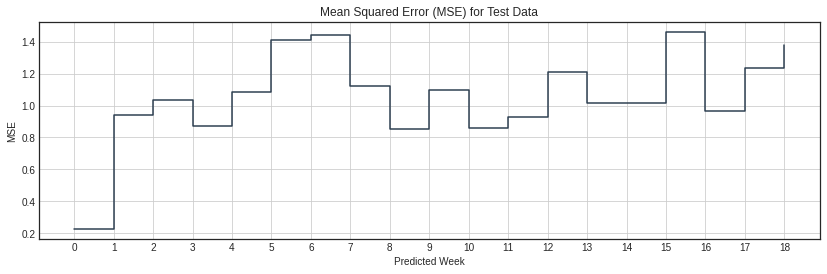

In [48]:
#  Plot MSE for all evaluated weeks
ax = pd.Series(evaluated_weeks).plot(drawstyle="steps-post",
                                     figsize=(14, 4),
                                     color='#2c3e50',
                                     grid=True,
                                     title='Mean Squared Error (MSE) for Test Data')

ax.set_xticks(range(0, len(evaluated_weeks)))
ax.set_xlabel("Predicted Week")
ax.set_ylabel("MSE")
plt.show()

In [49]:
#  Make predictions for each of the 19 weeks
#  in the test set
predicted_weeks = []
for i in range(0, test_data.shape[1]):
    input_series = combined_set[0:, i:i + 76]
    predicted_weeks.append(model.predict(input_series))

In [50]:
#  Flatten `predicted_weeks` to get a list
#  of predictions for each day in the 19 weeks
predicted_days = []
for week in predicted_weeks:
    predicted_days += list(week[0])

In [51]:
#  Create list of dates associated with predictions
last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
list_of_days = []
for days in range(1, len(predicted_days) + 1):
    D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
    list_of_days.append(D)

In [52]:
#  Create dataframe with predicted values
predicted = pd.DataFrame({
    'date': list_of_days,
    'close_point_relative_normalization': predicted_days
})
predicted.head()

,date,close_point_relative_normalization
0,2017-06-25,-0.790166
1,2017-06-26,-0.223829
2,2017-06-27,0.653877
3,2017-06-28,0.455602
4,2017-06-29,0.146022


In [53]:
#  Convert `date` variable to datetime
predicted['date'] = predicted['date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))

test['date'] = test['date'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [54]:
def plot_two_series(A, B, variable, title):
    """Plot two series using the same `date` index. 
    
    Parameters
    ----------
    A, B: pd.DataFrame
        Dataframe with a `date` key and a variable
        passed in the `variable` parameter. Parameter A
        represents the "Observed" series and B the "Predicted"
        series. These will be labelled respectively. 
    
    variable: str
        Variable to use in plot.
    
    title: str
        Plot title.
    """
    plt.figure(figsize=(14, 4))
    plt.xlabel('Observed and predicted')

    ax1 = A.set_index('date')[variable].plot(
        color='#d35400', grid=True, label='Observed', title=title)

    ax2 = B.set_index('date')[variable].plot(
        color='grey', grid=True, label='Predicted')
    
    ax1.set_xlabel("Predicted Week")
    ax1.set_ylabel("Predicted Values")

    plt.legend()
    plt.show()

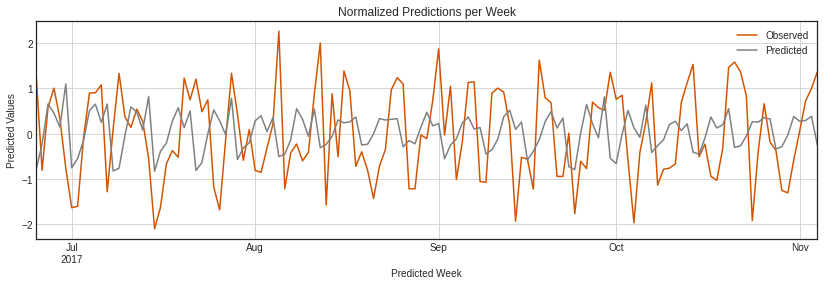

In [55]:
#  Plot predicted normalized prices
#  against actual normalized prices
plot_two_series(A=test[:-3],
                B=predicted,
                variable='close_point_relative_normalization',
                title='Normalized Predictions per Week')

In [56]:
#  Add variable `iso_week` by stripping the Year and Week from `date`
predicted['iso_week'] = predicted['date'].apply(
    lambda x: x.strftime('%Y-%U'))

In [57]:
def denormalize(reference, series,
                normalized_variable='close_point_relative_normalization',
                denormalized_variable='close'):
    """Denormalize the values for a given series.

    Parameters
    ----------
    reference: pd.DataFrame
        DataFrame to use as reference. This dataframe
        contains both a week index and the USD price
        reference that we are interested on.

    series: pd.DataFrame
        DataFrame with the predicted series. The
        DataFrame must have the same columns as the
        `reference` dataset.

    normalized_variable: str, default 'close_point_relative_normalization'
        Variable to use in normalization.

    denormalized_variable: str, default `close`
        Variable to use in de-normalization.

    Returns
    -------
    A modified DataFrame with the new variable provided
    in `denormalized_variable` parameter.
    """
    week_values = reference[reference['iso_week'] == series['iso_week'].values[0]]
    last_value = week_values[denormalized_variable].values[0]
    series[denormalized_variable] = last_value * (series[normalized_variable] + 1)

    return series

In [58]:
#  Denormalize predictions
predicted_close = predicted.groupby('iso_week').apply(
    lambda x: denormalize(test[:-3], x))

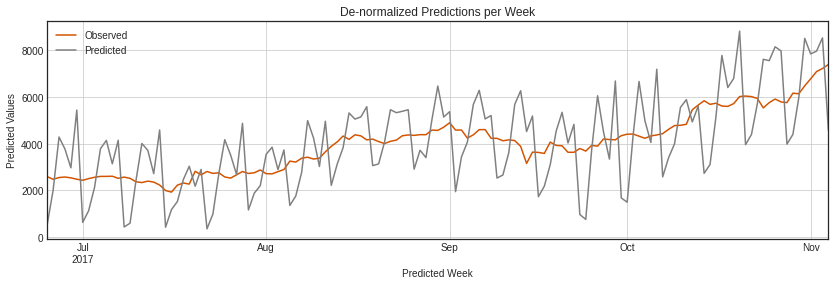

In [59]:
#  Plot denormalized predictions and observed closing prices in test set
plot_two_series(A=test[:-3],
                B=predicted_close,
                variable='close',
                title='De-normalized Predictions per Week')

In [60]:
A = test[:-3]['close_point_relative_normalization']
B = predicted_close['close_point_relative_normalization']

print(f'Normalized RMSE: {rmse(A, B):.2f}')

Normalized RMSE: 1.07


In [61]:
A = test[:-3]['close']
B = predicted_close['close']

print(f'De-normalized RMSE: {rmse(A, B):.2f}')
print(f'De-normalized MAPE: {mape(A, B):.2f}')

De-normalized RMSE: 1487.68
De-normalized MAPE: 34.24


In [62]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [63]:
from keras.models import load_model
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.callbacks import TensorBoard
from keras.layers.core import Dense, Activation, Dropout, ActivityRegularization

In [71]:
from utilities_activity7 import (create_groups, split_lstm_input, 
                               train_model, plot_two_series, rmse, 
                               mape, denormalize)

In [72]:
plt.style.use('seaborn-white')

In [73]:
np.random.seed(0)

In [74]:
train = pd.read_csv('/content/train_dataset.csv')

In [75]:
test = pd.read_csv('/content/test_dataset.csv')

In [76]:
train_data = create_groups(
    train['close_point_relative_normalization'].values)

In [77]:
test_data = create_groups(
    test['close_point_relative_normalization'].values)

In [78]:
X_train, Y_train = split_lstm_input(train_data)

In [79]:
model_v0 = load_model('bitcoin_lstm_v0.h5')

In [80]:
%%time
train_model(model=model_v0, X=X_train, Y=Y_train, epochs=100, version=0, run_number=0)

Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6975
Epoch 2/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 8ms/step - loss: 0.6688
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 0.6489
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6326
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6183
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6054
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.5935
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5822
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5715
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.5613
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.5514
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - lo

In [81]:
period_length = 7
number_of_periods = 76
batch_size=1

In [82]:
model_v1 = Sequential()
model_v1.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#
#  Add new LSTM layer to this network here.
#

model_v1.add(Dense(units=period_length))
model_v1.add(Activation("linear"))

model_v1.compile(loss="mse", optimizer="rmsprop")

In [83]:
%%time
train_model(model=model_v1, X=X_train, Y=Y_train, epochs=100, version=1, run_number=0)

Epoch 1/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7814
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7654
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.7542
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7450
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7369
Epoch 6/100
1/1 [==============================] - 0s 4ms/step - loss: 0.7296
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7227
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7163
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7100
Epoch 10/100
1/1 [==============================] - 0s 11ms/step - loss: 0.7041
Epoch 11/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6982
Epoch 12/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6925
Epoch 13/100
1/1 [==============================] - 0s 3ms/s

In [84]:
#
#  Change the number of epochs below
#  to a higher number (try 10**3) and
#  evaluate the results on TensorBoard.
#
number_of_epochs = 300

In [85]:
model_v2 = Sequential()
model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v2.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v2.add(Dense(units=period_length))
model_v2.add(Activation("linear"))

model_v2.compile(loss="mse", optimizer="rmsprop")

In [86]:
%%time
train_model(model=model_v2, X=X_train, Y=Y_train, epochs=number_of_epochs, 
            version=2, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 9ms/step - loss: 0.9556
Epoch 2/300
1/1 [==============================] - 0s 2ms/step - loss: 0.9213
Epoch 3/300
1/1 [==============================] - 0s 3ms/step - loss: 0.8983
Epoch 4/300
1/1 [==============================] - 0s 3ms/step - loss: 0.8798
Epoch 5/300
1/1 [==============================] - 0s 3ms/step - loss: 0.8640
Epoch 6/300
1/1 [==============================] - 0s 3ms/step - loss: 0.8497
Epoch 7/300
1/1 [==============================] - 0s 3ms/step - loss: 0.8365
Epoch 8/300
1/1 [==============================] - 0s 3ms/step - loss: 0.8241
Epoch 9/300
1/1 [==============================] - 0s 2ms/step - loss: 0.8122
Epoch 10/300
1/1 [==============================] - 0s 3ms/step - loss: 0.8006
Epoch 11/300
1/1 [==============================] - 0s 3ms/step - loss: 0.7894
Epoch 12/300
1/1 [==============================] - 0s 3ms/step - loss: 0.7784
Epoch 13/300
1/1 [==============================] - 0s 3ms/st

In [87]:
#
#  Instead of using a ReLU, visit
#  the Keras official documentation (https://keras.io/activations/)
#  and choose a different function to try (maybe "tanh").
#
activation_function = "linear"

In [88]:
model_v3 = Sequential()
model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

model_v3.add(Dense(units=period_length))
model_v3.add(Activation(activation_function))

model_v3.compile(loss="mse", optimizer="rmsprop")

In [89]:
%%time
train_model(model=model_v3, X=X_train, Y=Y_train, epochs=300, 
            version=3, run_number=0)

Epoch 1/300
1/1 [==============================] - 0s 6ms/step - loss: 0.8030
Epoch 2/300
1/1 [==============================] - 0s 3ms/step - loss: 0.7679
Epoch 3/300
1/1 [==============================] - 0s 4ms/step - loss: 0.7443
Epoch 4/300
1/1 [==============================] - 0s 6ms/step - loss: 0.7248
Epoch 5/300
1/1 [==============================] - 0s 3ms/step - loss: 0.7073
Epoch 6/300
1/1 [==============================] - 0s 3ms/step - loss: 0.6909
Epoch 7/300
1/1 [==============================] - 0s 3ms/step - loss: 0.6752
Epoch 8/300
1/1 [==============================] - 0s 2ms/step - loss: 0.6599
Epoch 9/300
1/1 [==============================] - 0s 3ms/step - loss: 0.6449
Epoch 10/300
1/1 [==============================] - 0s 3ms/step - loss: 0.6301
Epoch 11/300
1/1 [==============================] - 0s 3ms/step - loss: 0.6153
Epoch 12/300
1/1 [==============================] - 0s 3ms/step - loss: 0.6005
Epoch 13/300
1/1 [==============================] - 0s 3ms/st

In [98]:
model_v3 = Sequential()
model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=True, stateful=False))

#
#  Implement a Dropout() here.
model_v3.add(Dropout(0.2))
#

model_v3.add(LSTM(
    units=period_length,
    batch_input_shape=(batch_size, number_of_periods, period_length),
    input_shape=(number_of_periods, period_length),
    return_sequences=False, stateful=False))

#
#  Implement a Dropout() here too.
model_v3.add(Dropout(0.2))
#

model_v3.add(Dense(units=period_length))
model_v3.add(Activation(activation_function))

model_v3.compile(loss="mse", optimizer="rmsprop")

In [99]:
%%time
train_model(model=model_v3, X=X_train, Y=Y_train, epochs=600, 
            version=3, run_number=0)

Epoch 1/600
1/1 [==============================] - 0s 6ms/step - loss: 0.7514
Epoch 2/600
1/1 [==============================] - 0s 3ms/step - loss: 0.8098
Epoch 3/600
1/1 [==============================] - 0s 5ms/step - loss: 0.7181
Epoch 4/600
1/1 [==============================] - 0s 3ms/step - loss: 0.7541
Epoch 5/600
1/1 [==============================] - 0s 4ms/step - loss: 0.7510
Epoch 6/600
1/1 [==============================] - 0s 2ms/step - loss: 0.7486
Epoch 7/600
1/1 [==============================] - 0s 3ms/step - loss: 0.6989
Epoch 8/600
1/1 [==============================] - 0s 4ms/step - loss: 0.7206
Epoch 9/600
1/1 [==============================] - 0s 3ms/step - loss: 0.6177
Epoch 10/600
1/1 [==============================] - 0s 5ms/step - loss: 0.6400
Epoch 11/600
1/1 [==============================] - 0s 4ms/step - loss: 0.6495
Epoch 12/600
1/1 [==============================] - 0s 4ms/step - loss: 0.6861
Epoch 13/600
1/1 [==============================] - 0s 3ms/st

In [100]:
combined_set = np.concatenate((train_data, test_data), axis=1)

In [101]:
def evaluate_model(model, kind='series'):
    """
    Uses Keras model.evaluate() method to compute
    the MSE for all future weeks in period.
    
    Parameters
    ----------
    model: Keras trained model
    
    kind: str, default 'series'
        Kind of evaluation to perform. If 'series', 
        then the model will perform an evaluation 
        over the complete series.
    
    Returns
    -------
    evaluated_weeks: list
        List of MSE values for each evaluated
        test week.
    """
    if kind == 'series':
        predicted_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+76]
            predicted_weeks.append(model.predict(input_series))

        predicted_days = []
        for week in predicted_weeks:
            predicted_days += list(week[0])

        return predicted_days
    else:
        evaluated_weeks = []
        for i in range(0, test_data.shape[1]):
            input_series = combined_set[0:,i:i+77]

            X_test = input_series[0:,:-1].reshape(1, input_series.shape[1] - 1, 7)
            Y_test = input_series[0:,-1:][0]

            result = model.evaluate(x=X_test, y=Y_test, verbose=0)
            evaluated_weeks.append(result)
            
            return evaluated_weeks

In [102]:
def plot_weekly_mse(series, model_name, color):
    ax = pd.Series(series).plot(drawstyle="steps-post",
                                figsize=(14,4),
                                linewidth=2,
                                color=color,
                                grid=True,
                                label=model_name,
                                alpha=0.7,
                                title='Mean Squared Error (MSE) for Test Data (all models)'.format(
                                       model_name))

    y = [i for i in range(0, len(series))]
    yint = range(min(y), math.ceil(max(y))+1)
    plt.xticks(yint)

    ax.set_xlabel("Predicted Week")
    ax.set_ylabel("MSE")
    
    return ax

In [103]:
def plot_weekly_predictions(predicted_days, name, display_plot=True, 
                            variable='close'):
    
    combined = pd.concat([train, test])
    
    last_day = datetime.strptime(train['date'].max(), '%Y-%m-%d')
    list_of_days = []
    for days in range(1, len(predicted_days) + 1):
        D = (last_day + timedelta(days=days)).strftime('%Y-%m-%d')
        list_of_days.append(D)
    
    predicted = pd.DataFrame({
        'date': list_of_days, 
        'close_point_relative_normalization': predicted_days 
    })
    
    combined['date'] = combined['date'].apply(
                    lambda x: datetime.strptime(x, '%Y-%m-%d'))
    
    predicted['date'] = predicted['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    
    observed = combined[combined['date'] > train['date'].max()]
    
    predicted['iso_week'] = predicted['date'].apply(
                            lambda x: x.strftime('%Y-%U'))
    
    predicted_close = predicted.groupby('iso_week').apply(
                            lambda x: denormalize(observed, x))
    
    plot_two_series(observed, predicted_close, 
                    variable=variable,
                    title='{}: Predictions per Week'.format(name))
    
    print('RMSE: {:.4f}'.format(
        rmse(observed[variable][:-3], 
             predicted_close[variable])))

    print('MAPE: {:.1f}%'.format(
        mape(observed[variable][:-3], 
             predicted_close[variable])))

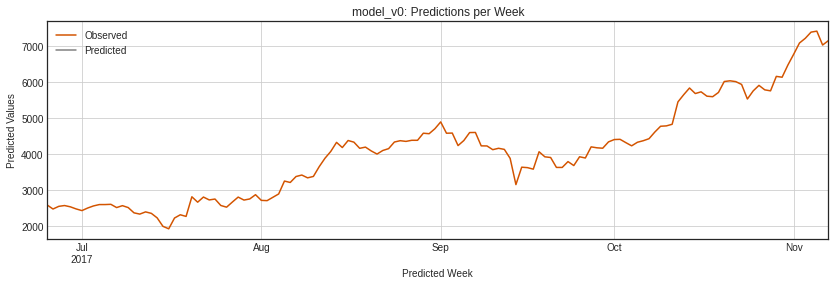

RMSE: 235.8111
MAPE: 9.1%


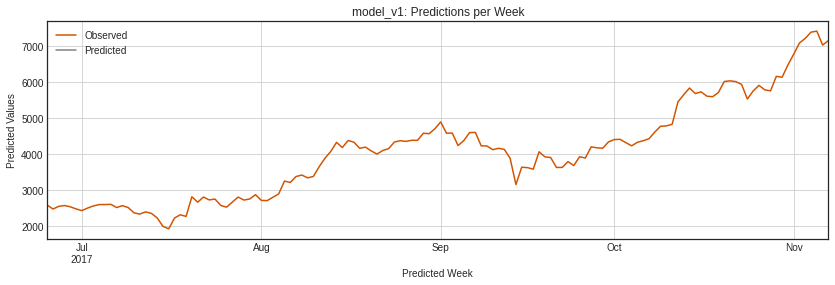

RMSE: 447.8557
MAPE: 17.3%


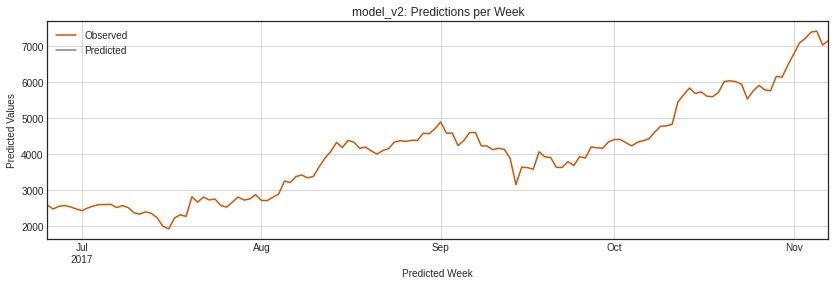

RMSE: 0.0698
MAPE: 0.0%


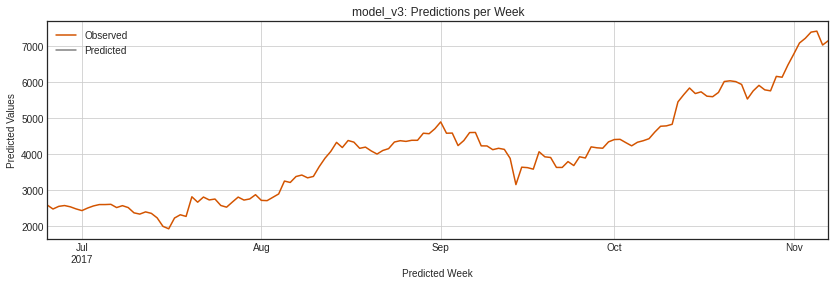

RMSE: 2.7326
MAPE: 0.1%


In [104]:
models = [model_v0, model_v1, model_v2, model_v3]
for i, M in enumerate(models):
    predicted_days = evaluate_model(M, kind='other')
    plot_weekly_predictions(predicted_days, 'model_v{}'.format(i), display_plot=False)